In [1]:
import numpy as np
import pandas as pd 
import copy
import os

import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle, randint
from numpy import mean, std, dstack
from pandas import read_csv


from keras import backend as K
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model, Sequential
from keras.layers import (Input, Dense, Flatten, Dropout, Conv1D, LSTM, GRU,
                          TimeDistributed, GlobalAveragePooling1D, MaxPooling1D)
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from keras.optimizers import Adam, RMSprop,SGD
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from scipy import signal

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
with pd.option_context("display.max_rows", 10, "display.max_columns", 20):
    print(pd.get_option("display.max_rows")) 
    print(pd.get_option("display.max_columns"))
    

Using TensorFlow backend.
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python

10
20


/home/jurgen/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorboard/compat/ten

In [2]:
cd ..

/home/jurgen/PycharmProjects/SygnalAnalysis


# Declare common display graphics functions

In [3]:
def display_block_of_values(dataframe=pd.DataFrame, x_label='x_label', y_label='y_label',figsize=(15,30), plot_size=(30,2)):
    assert isinstance(dataframe, pd.DataFrame)
    plt.figure(figsize=figsize)
    for index, col in enumerate(dataframe.columns):
        plt.subplot(plot_size[0],plot_size[1], index+1)
        plt.plot(dataframe[col])
        plt.title(col)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.tight_layout()
        
        
def display_distribution_graphic(data_frame, suptitle='key'):
    plt.figure(figsize=(15,15))
    plt.suptitle(suptitle, fontsize=16)
    for ind, col in enumerate(data_frame.columns):
        plt.subplot(5,5, ind+1)
        plt.hist(data_frame[col])
        plt.title(col)
        plt.xlabel("Amplitude")
        plt.ylabel("Counts")
        plt.tight_layout()
        

In [6]:
from core.controller import GasolineSignalController
signals = GasolineSignalController(filepath="/media/jurgen/Новый том/Sygnaldatasets/kaspersky/GHL/01_Lev_fault_Temp_corr_seed_11_vars_23.csv", 
                           encoding="cp1251", delimiter=",",corr_threshold=0.9)

Read Gasoline 
Number of columns: 23
Number of columns after clean: 23
Number of columns after corr analysis: 17
savgol filter smoothing successful
successfully scaled control_results
successfully scaled savgol filter control results


In [11]:
signals.control_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204560 entries, 0 to 204559
Data columns (total 17 columns):
Time                204560 non-null float64
RT_level_ini        204560 non-null float64
DANGER              204560 non-null float64
FAULT               204560 non-null float64
RT_temperature.T    204560 non-null float64
C_temperature.T     204560 non-null float64
RT_level            204560 non-null float64
out_valve_act       204560 non-null float64
dT_rand             204560 non-null float64
inv_valve_act       204560 non-null float64
inj_valve_act       204560 non-null float64
Relaxing.active     204560 non-null float64
dir_valve_act       204560 non-null float64
dt_rand             204560 non-null float64
HT_temperature.T    204560 non-null float64
heater_act          204560 non-null float64
ATTACK              204560 non-null float64
dtypes: float64(17)
memory usage: 26.5 MB


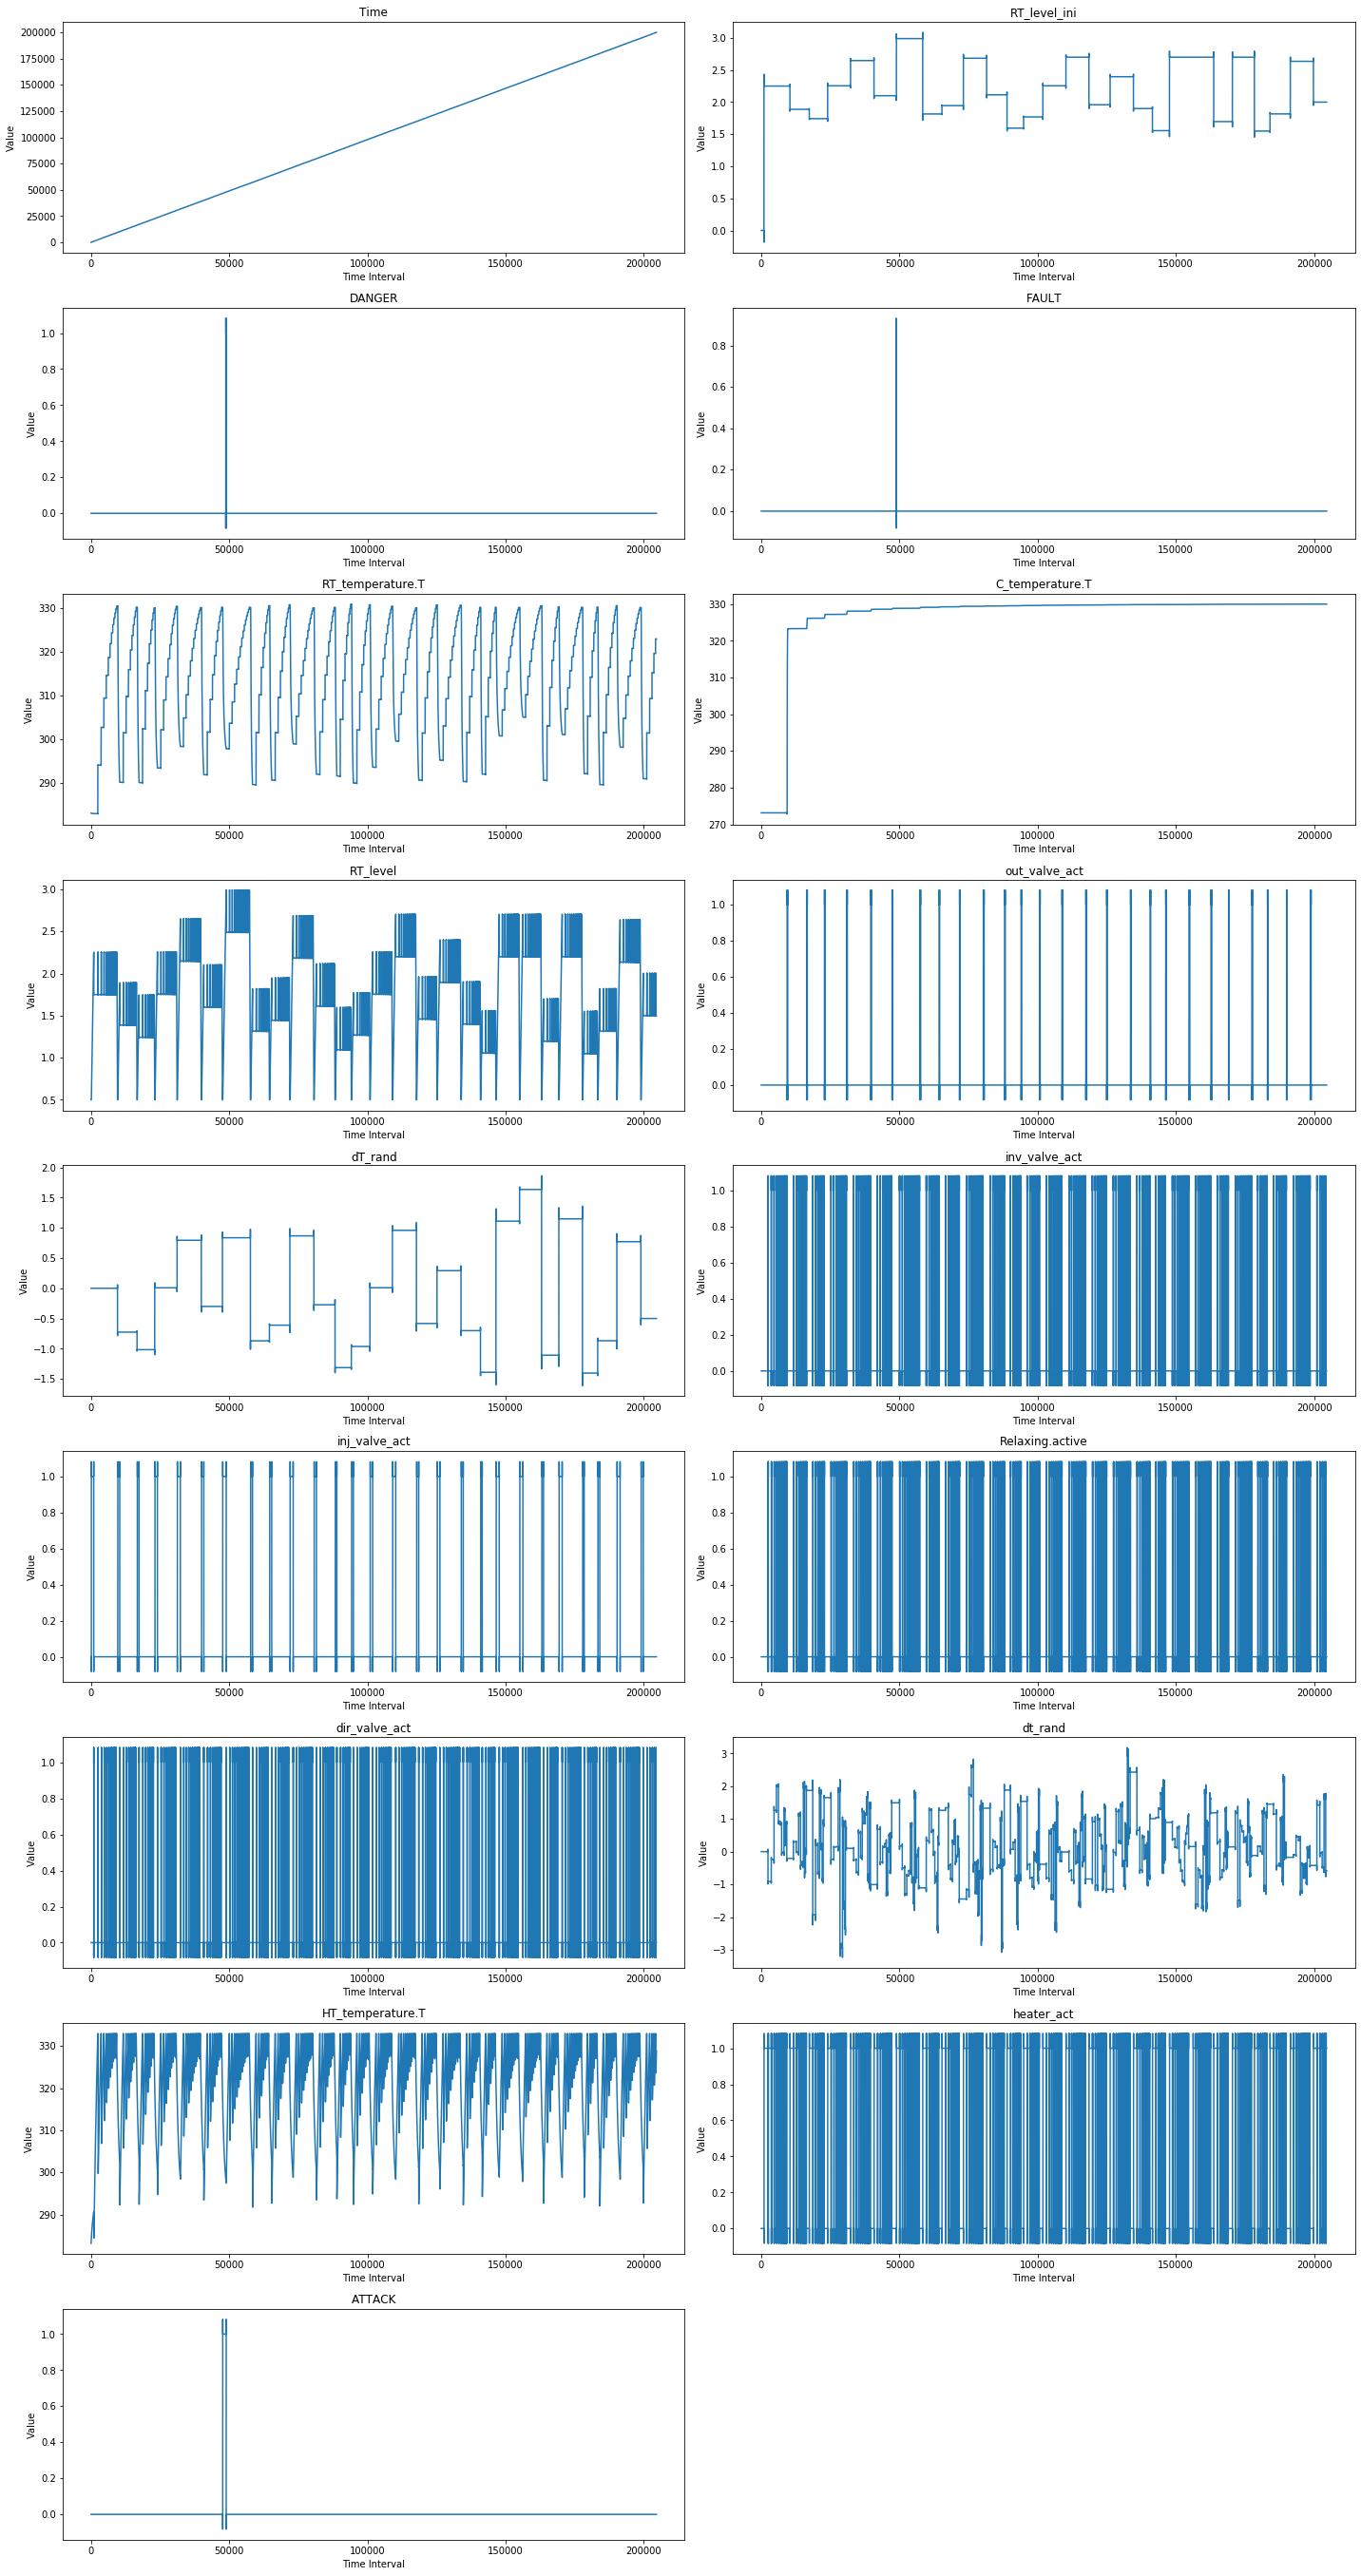

In [10]:
display_block_of_values(signals.savgol_filter_smoothing,
              x_label='Time Interval',
              y_label='Value', 
              figsize=(20, 100),
              plot_size=(24,2))

План работы с GHL dataset - 
- Загрузить все образцы из хранилища c помощью SignalController 
- Разделить каждый образец на 4, 8, 16 (выбрать) подобразцом с наличием и аномальных и безаномальных участков 
- Разделить целевой и информативный признаки 
- Произвести корреляционную проверку, стандартизирование, сглаживание 
- Подготовить конфигурацию нейронной сети под признаковое пространство 
- Подготовить набор данных для обучения и тестирования алгоритма 
- Обучить модель 